# 00: Feature Pull from Spotify

The starting point for this project, naturally, is extracting my music from Spotify via the Spotify API. Ultimately, I want to have a UI where I can input either a playlist, or a collection (2+) of artists, from which the graph will expand outwards from. So, I need some to establish the pipeline of grabbing that information, and also just to grab starter data. 

In [3]:
import pandas as pd
import numpy as np
import json
import spotipy
import re
import os
from dotenv import load_dotenv
from spotipy.oauth2 import SpotifyClientCredentials

### Set up

In [4]:
load_dotenv()

True

In [5]:
CLIENT_ID = os.environ.get("SPOTIFY_CLIENT_ID")
CLIENT_SECRET = os.environ.get("SPOTIFY_CLIENT_SECRET")

In [6]:
auth_manager = SpotifyClientCredentials(client_id=CLIENT_ID,
                                        client_secret=CLIENT_SECRET)
sp = spotipy.Spotify(auth_manager=auth_manager)

### Test Playlist

In [10]:
hardnheavy_url = "https://open.spotify.com/playlist/142oZDOc1za2dkUwyonA1P?si=9477d01b58b34669"

In [65]:
# grab artists in my hard n heavy playlist
response = sp.playlist_tracks(hardnheavy_url, offset=0)
artists = [track["track"]["artists"][0] for track in response["items"]]
total = response["total"]

for offset in range(100, total + 1, 100): 

    response = sp.playlist_tracks(hardnheavy_url, offset=offset)
    artists += [track["track"]["artists"][0] for track in response["items"]]

artists[:5]

[{'external_urls': {'spotify': 'https://open.spotify.com/artist/3Ri4H12KFyu98LMjSoij5V'},
  'href': 'https://api.spotify.com/v1/artists/3Ri4H12KFyu98LMjSoij5V',
  'id': '3Ri4H12KFyu98LMjSoij5V',
  'name': 'Bad Omens',
  'type': 'artist',
  'uri': 'spotify:artist:3Ri4H12KFyu98LMjSoij5V'},
 {'external_urls': {'spotify': 'https://open.spotify.com/artist/3Ri4H12KFyu98LMjSoij5V'},
  'href': 'https://api.spotify.com/v1/artists/3Ri4H12KFyu98LMjSoij5V',
  'id': '3Ri4H12KFyu98LMjSoij5V',
  'name': 'Bad Omens',
  'type': 'artist',
  'uri': 'spotify:artist:3Ri4H12KFyu98LMjSoij5V'},
 {'external_urls': {'spotify': 'https://open.spotify.com/artist/3Ri4H12KFyu98LMjSoij5V'},
  'href': 'https://api.spotify.com/v1/artists/3Ri4H12KFyu98LMjSoij5V',
  'id': '3Ri4H12KFyu98LMjSoij5V',
  'name': 'Bad Omens',
  'type': 'artist',
  'uri': 'spotify:artist:3Ri4H12KFyu98LMjSoij5V'},
 {'external_urls': {'spotify': 'https://open.spotify.com/artist/3Ri4H12KFyu98LMjSoij5V'},
  'href': 'https://api.spotify.com/v1/artis

Some things to consider about the above - 

* I am for now just taking the primary artist of each song. Features can also be taken if I want; I can leave it as a toggle for the user when extracting the playlist artists.
  * Same thing with weighing artists by the proportion of their songs in the playlist. Leave it as a user option. But for now I will not mind that.

In [66]:
total, len(artists)

(376, 376)

In [70]:
artist_names = [artist["name"] for artist in artists]
len(set(artist_names))

48

In [71]:
artist_uris = [artist["uri"] for artist in artists]

In [75]:
sp.artist(artist_uris[0])

{'external_urls': {'spotify': 'https://open.spotify.com/artist/3Ri4H12KFyu98LMjSoij5V'},
 'followers': {'href': None, 'total': 1776121},
 'genres': ['metalcore'],
 'href': 'https://api.spotify.com/v1/artists/3Ri4H12KFyu98LMjSoij5V',
 'id': '3Ri4H12KFyu98LMjSoij5V',
 'images': [{'url': 'https://i.scdn.co/image/ab6761610000e5eb3a62c74a31a446406a033926',
   'height': 640,
   'width': 640},
  {'url': 'https://i.scdn.co/image/ab676161000051743a62c74a31a446406a033926',
   'height': 320,
   'width': 320},
  {'url': 'https://i.scdn.co/image/ab6761610000f1783a62c74a31a446406a033926',
   'height': 160,
   'width': 160}],
 'name': 'Bad Omens',
 'popularity': 75,
 'type': 'artist',
 'uri': 'spotify:artist:3Ri4H12KFyu98LMjSoij5V'}

In [78]:
sp.artist_albums(artist_uris[0])["items"][0].keys()

dict_keys(['album_type', 'total_tracks', 'available_markets', 'external_urls', 'href', 'id', 'images', 'name', 'release_date', 'release_date_precision', 'type', 'uri', 'artists', 'album_group'])

Really there is not a lot of artist-level information that can be retrieved using the Spotify API. The only general information available is: 

* number of followers
* popularity
* genre (has now become far less specific than it used to be; broad genres would be of very little use)
  * Regarding more specific genres, Spotify has deprecated lots of endpoints and limited the data retrieved from those still available, and genres were affected as such. Old applications may still be able to use those features, though - note [exportify](https://exportify.net/) is able to grab audio features and more specific genres. Someone built a cli [here](https://github.com/donmerendolo/exportify-cli) that can be used to automate the process. Other APIs I can look into are MusicBrainz, Lastfm, and Discogs; the former two result in user-curated tags and so are not ideal, while the latter has more formal tags but are associated with releases as opposed to artist (so need to be aggregated, which is fine). The thing with all the alternative APIs though is that artists need to be corresponded to those taken from Spotify. Try exportify first.

In [83]:
features = pd.read_csv("hardnheavy_exportify.csv")
features

,Track URI,Track Name,Album Name,Artist Name(s),Release Date,Duration (ms),Popularity,Explicit,Added By,Added At,...,Key,Loudness,Mode,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo,Time Signature
0,spotify:track:6yCysJaY0lFqHnrHvaR4pF,CONCRETE JUNGLE,THE DEATH OF PEACE OF MIND,Bad Omens,2022-02-25,220495,69,True,bananaslug-10,2024-09-04T15:05:50Z,...,1,-5.265,1,0.0402,0.001020,0.004230,0.0697,0.444,91.964,4
1,spotify:track:4TzGD5Pryq8DTjv5QRuJaW,Nowhere To Go,THE DEATH OF PEACE OF MIND,Bad Omens,2022-02-25,246774,71,True,bananaslug-10,2024-09-04T15:05:50Z,...,7,-3.413,1,0.1360,0.000774,0.000000,0.1750,0.457,174.094,4
2,spotify:track:6ERSCeGFBSwvHCvBjwrmwE,Take Me First,THE DEATH OF PEACE OF MIND,Bad Omens,2022-02-25,199685,65,False,bananaslug-10,2024-09-04T15:05:50Z,...,4,-3.908,0,0.0975,0.001180,0.000009,0.1190,0.439,164.249,4
3,spotify:track:6tRneEcItwpSxBtqgem5Dr,THE DEATH OF PEACE OF MIND,THE DEATH OF PEACE OF MIND,Bad Omens,2022-02-25,241499,78,True,bananaslug-10,2024-09-04T15:05:50Z,...,0,-5.619,0,0.0461,0.086900,0.000188,0.1290,0.267,154.994,4
4,spotify:track:0XL8gRZn7tUoYgq9nLZhjU,What It Cost,THE DEATH OF PEACE OF MIND,Bad Omens,2022-02-25,103744,61,False,bananaslug-10,2024-09-04T15:05:50Z,...,11,-5.706,0,0.0810,0.020600,0.077100,0.1350,0.390,155.158,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
371,spotify:track:5hPjTibz6wInfJQvImFp9I,Don't Reach For Me,You Won't Go Before You're Supposed To,Knocked Loose,2024-05-10,225240,61,True,bananaslug-10,2025-07-03T05:17:59Z,...,1,-2.594,0,0.2840,0.000079,0.001070,0.1740,0.154,144.959,3
372,spotify:track:12KkNzIniU4U2LAHNgVDvw,Blinding Faith,You Won't Go Before You're Supposed To,Knocked Loose,2024-05-10,171090,62,False,bananaslug-10,2025-06-27T15:54:03Z,...,9,-2.540,1,0.2260,0.000015,0.019300,0.2150,0.218,165.887,4
373,spotify:track:7sSnydn10cmiEDOd4hPKxU,Piece By Piece,You Won't Go Before You're Supposed To,Knocked Loose,2024-05-10,171176,54,False,bananaslug-10,2025-06-27T16:00:52Z,...,9,-1.838,1,0.2370,0.000013,0.002920,0.5220,0.115,174.752,4
374,spotify:track:6XpWCxEdQDbHygtWnBY9Eu,Everything is Quiet Now,Upon Loss Singles,Knocked Loose,2023-06-14,215567,57,False,bananaslug-10,2025-07-03T05:58:11Z,...,9,-3.242,0,0.2460,0.000648,0.028500,0.2460,0.147,128.163,4


In [84]:
features.columns

Index(['Track URI', 'Track Name', 'Album Name', 'Artist Name(s)',
       'Release Date', 'Duration (ms)', 'Popularity', 'Explicit', 'Added By',
       'Added At', 'Genres', 'Record Label', 'Danceability', 'Energy', 'Key',
       'Loudness', 'Mode', 'Speechiness', 'Acousticness', 'Instrumentalness',
       'Liveness', 'Valence', 'Tempo', 'Time Signature'],
      dtype='object')

In [98]:
genres = [genre.strip() for ls in features["Genres"] if isinstance(ls, str) for genre in ls.split(",")]
genres

['metalcore',
 'metalcore',
 'metalcore',
 'metalcore',
 'metalcore',
 'metalcore',
 'metalcore',
 'metalcore',
 'metalcore',
 'metalcore',
 'metalcore',
 'metalcore',
 'metalcore',
 'metalcore',
 'metalcore',
 'metalcore',
 'metalcore',
 'metalcore',
 'metalcore',
 'metalcore',
 'metalcore',
 'metalcore',
 'metalcore',
 'metalcore',
 'metalcore',
 'metalcore',
 'metalcore',
 'metalcore',
 'djent',
 'progressive metal',
 'metal',
 'deathcore',
 'post-hardcore',
 'metalcore',
 'metalcore',
 'metalcore',
 'noise rock',
 'witch house',
 'industrial',
 'deathstep',
 'metalcore',
 'metalcore',
 'metalcore',
 'metalcore',
 'metalcore',
 'metalcore',
 'metalcore',
 'metalcore',
 'metalcore',
 'metalcore',
 'metalcore',
 'metalcore',
 'metalcore',
 'metalcore',
 'metalcore',
 'metalcore',
 'progressive metal',
 'metalcore',
 'progressive metal',
 'metalcore',
 'progressive metal',
 'metalcore',
 'progressive metal',
 'metalcore',
 'progressive metal',
 'metalcore',
 'progressive metal',
 'meta

In [99]:
set(genres)

{'alternative metal',
 'death metal',
 'deathcore',
 'deathstep',
 'djent',
 'dream pop',
 'emo',
 'groove metal',
 'hard rock',
 'hardcore',
 'hardcore punk',
 'industrial',
 'math rock',
 'mathcore',
 'melodic hardcore',
 'metal',
 'metalcore',
 'midwest emo',
 'noise rock',
 'nu metal',
 'pop punk',
 'post-hardcore',
 'progressive metal',
 'progressive rock',
 'punk',
 'rap metal',
 'rap rock',
 'retro soul',
 'riot grrrl',
 'rock',
 'screamo',
 'shoegaze',
 'witch house'}

In [100]:
from collections import Counter

In [102]:
genre_counts = Counter(genres)
genre_counts

Counter({'metalcore': 287,
         'djent': 48,
         'progressive metal': 49,
         'metal': 110,
         'deathcore': 40,
         'post-hardcore': 53,
         'noise rock': 1,
         'witch house': 1,
         'industrial': 1,
         'deathstep': 1,
         'emo': 8,
         'screamo': 39,
         'rock': 19,
         'mathcore': 14,
         'alternative metal': 60,
         'nu metal': 41,
         'rap metal': 41,
         'shoegaze': 37,
         'dream pop': 1,
         'riot grrrl': 1,
         'melodic hardcore': 2,
         'pop punk': 3,
         'hardcore': 8,
         'hardcore punk': 7,
         'groove metal': 1,
         'death metal': 4,
         'progressive rock': 11,
         'rap rock': 5,
         'hard rock': 1,
         'midwest emo': 1,
         'punk': 1,
         'retro soul': 1,
         'math rock': 1})

In [104]:
import matplotlib.pyplot as plt

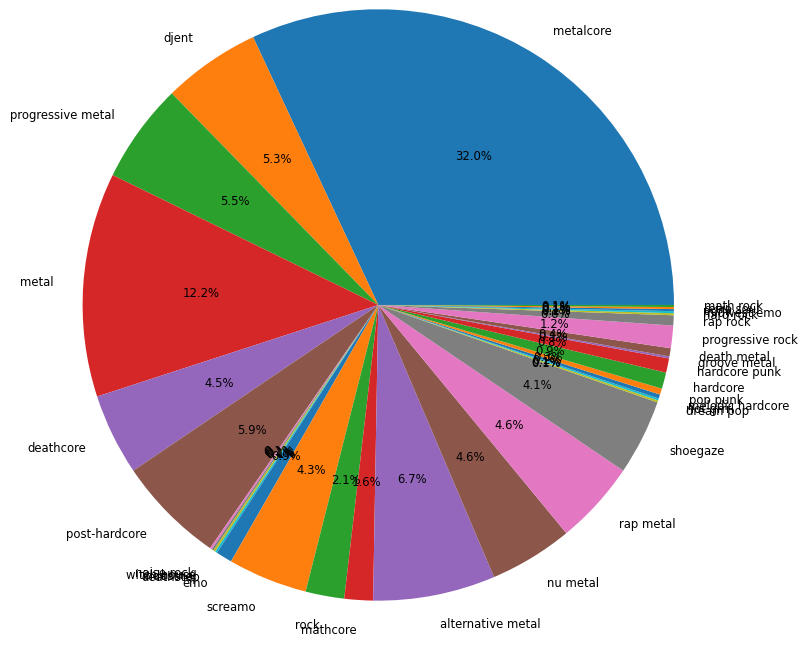

In [108]:
labels = genre_counts.keys()
sizes = genre_counts.values()

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.1f%%', radius=2, textprops={'size': 'smaller'})
plt.show()

In [117]:
features[features["Genres"].astype(str).str.contains("djent")][["Track Name", "Artist Name(s)", "Genres", "Popularity"]]

,Track Name,Artist Name(s),Genres,Popularity
27,ANYTHING > HUMAN,"Bad Omens,ERRA","metalcore,djent,progressive metal,metal,deathc...",65
109,Curse,Architects,"metalcore,djent,mathcore,metal,post-hardcore,d...",28
135,Animals,Architects,"metalcore,djent,mathcore,metal,post-hardcore,d...",74
136,Seeing Red,Architects,"metalcore,djent,mathcore,metal,post-hardcore,d...",28
186,Mea Culpa (Ah! Ça ira!),"Gojira,Marina Viotti,Victor Le Masne","groove metal,metal,progressive metal,death met...",64
248,Circle With Me,Spiritbox,"metalcore,djent,metal",74
249,Cellar Door,Spiritbox,"metalcore,djent,metal",54
250,Jaded,Spiritbox,"metalcore,djent,metal",71
251,Soft Spine,Spiritbox,"metalcore,djent,metal",59
252,Holy Roller,Spiritbox,"metalcore,djent,metal",64


In [121]:
features[features["Popularity"] <= 30]

,Track URI,Track Name,Album Name,Artist Name(s),Release Date,Duration (ms),Popularity,Explicit,Added By,Added At,...,Key,Loudness,Mode,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo,Time Signature
85,spotify:track:5evrhIjC3TWixy79nTaS0Z,They Don’t Even Know,For Keeps,Too Close To Touch,2024-03-08,197760,29,False,bananaslug-10,2024-10-04T17:56:12Z,...,2,-5.548,1,0.1230,0.000373,0.000203,0.4590,0.453,94.384,4
109,spotify:track:65VHUZPZKgaG4SJVRkBPzn,Curse,Curse,Architects,2024-04-09,181134,28,False,bananaslug-10,2024-09-04T15:10:45Z,...,5,-3.191,0,0.1430,0.000010,0.000036,0.1470,0.473,119.995,4
136,spotify:track:5EauhH7IW4eDo0SPnP6rIY,Seeing Red,Seeing Red,Architects,2023-12-04,220575,28,True,bananaslug-10,2024-09-23T17:14:28Z,...,7,-3.100,1,0.1430,0.000072,0.003240,0.0575,0.174,163.939,4
163,spotify:track:31iAZuJu1Obz239eDpMfee,Make Believe,Make Believe,Memphis May Fire,2022-02-18,229007,17,False,bananaslug-10,2024-11-06T23:30:15Z,...,2,-4.048,0,0.0701,0.002250,0.000070,0.1100,0.490,131.014,4
164,spotify:track:0cyRTLChgQDVxrHqI6uHtC,Blood & Water,Make Believe,Memphis May Fire,2022-02-18,230673,17,False,bananaslug-10,2024-11-06T23:30:25Z,...,1,-2.792,0,0.1890,0.000035,0.000004,0.3300,0.459,140.009,4
167,spotify:track:2lUECytCuzKCCDSsUdIqyC,Somebody,Make Believe,Memphis May Fire,2022-02-18,200000,13,False,bananaslug-10,2024-11-06T23:43:32Z,...,10,-2.801,0,0.1020,0.006610,0.000000,0.1040,0.637,137.979,4
168,spotify:track:3pTCy3GDllLC0wHXtMSVZh,Pretend,Pretend,The Plot In You,2024-09-27,185346,16,True,bananaslug-10,2024-11-07T00:10:08Z,...,0,-3.160,0,0.1430,0.000023,0.000116,0.2070,0.518,147.975,4


In [161]:
import requests
load_dotenv()
TM_API_KEY = os.environ.get("TM_API_KEY")
url = f"https://app.ticketmaster.com/discovery/v2/events.json?apikey={TM_API_KEY}&classificationName=music&keyword=thornhill"
response = requests.get(url)
response

<Response [200]>

In [162]:
url

'https://app.ticketmaster.com/discovery/v2/events.json?apikey=wtexzCHKziDUtKnAaFMvROFb2XebqjAo&classificationName=music&keyword=thornhill'

In [165]:
events = response.json()["_embedded"]["events"]
events
# aftershock_attractions = events[0]["_embedded"]["attractions"]
# len(aftershock_attractions)
# [att["name"] for att in aftershock_attractions]

[{'name': 'Thornhill',
  'type': 'event',
  'id': '17uOvxG65pLD-sg',
  'test': False,
  'url': 'https://www.ticketmaster.co.uk/thornhill-glasgow-04-11-2025/event/360062B59FEE1C75',
  'locale': 'en-us',
  'images': [{'ratio': '4_3',
    'url': 'https://s1.ticketm.net/dam/a/015/0aa6a367-c334-4db7-abe9-48241d870015_CUSTOM.jpg',
    'width': 305,
    'height': 225,
    'fallback': False},
   {'ratio': '16_9',
    'url': 'https://s1.ticketm.net/dam/a/015/0aa6a367-c334-4db7-abe9-48241d870015_TABLET_LANDSCAPE_16_9.jpg',
    'width': 1024,
    'height': 576,
    'fallback': False},
   {'ratio': '16_9',
    'url': 'https://s1.ticketm.net/dam/a/015/0aa6a367-c334-4db7-abe9-48241d870015_RETINA_LANDSCAPE_16_9.jpg',
    'width': 1136,
    'height': 639,
    'fallback': False},
   {'ratio': '16_9',
    'url': 'https://s1.ticketm.net/dam/a/015/0aa6a367-c334-4db7-abe9-48241d870015_EVENT_DETAIL_PAGE_16_9.jpg',
    'width': 205,
    'height': 115,
    'fallback': False},
   {'ratio': '3_2',
    'url': 'h

In [164]:
events.keys()

dict_keys(['events'])

In [156]:
aftershock_attractions

[{'name': 'Aftershock',
  'type': 'attraction',
  'id': 'K8vZ917fs67',
  'test': False,
  'url': 'https://www.ticketmaster.com/aftershock-tickets/artist/2248012',
  'locale': 'en-us',
  'externalLinks': {'twitter': [{'url': 'https://twitter.com/AFTERSHOCKSAC'}],
   'facebook': [{'url': 'https://www.facebook.com/AftershockFestival/'}],
   'instagram': [{'url': 'https://www.instagram.com/aftershockfestival/'}],
   'homepage': [{'url': 'https://aftershockfestival.com'}]},
  'images': [{'ratio': '16_9',
    'url': 'https://s1.ticketm.net/dam/a/7c5/1696e4d4-c49c-48ec-b26e-f81aa3fa57c5_RETINA_PORTRAIT_16_9.jpg',
    'width': 640,
    'height': 360,
    'fallback': False},
   {'ratio': '3_2',
    'url': 'https://s1.ticketm.net/dam/a/7c5/1696e4d4-c49c-48ec-b26e-f81aa3fa57c5_RETINA_PORTRAIT_3_2.jpg',
    'width': 640,
    'height': 427,
    'fallback': False},
   {'ratio': '16_9',
    'url': 'https://s1.ticketm.net/dam/a/7c5/1696e4d4-c49c-48ec-b26e-f81aa3fa57c5_RECOMENDATION_16_9.jpg',
    'wid

In [147]:
events[0]

{'name': 'Spiritbox w/ Periphery',
 'type': 'event',
 'id': 'Z7r9jZ1A7bMrv',
 'test': False,
 'url': 'https://www.ticketmaster.com/event/Z7r9jZ1A7bMrv',
 'locale': 'en-us',
 'images': [{'ratio': '16_9',
   'url': 'https://s1.ticketm.net/dam/c/060/c5c08e7a-9912-456c-a060-2758be94e060_105881_RECOMENDATION_16_9.jpg',
   'width': 100,
   'height': 56,
   'fallback': True},
  {'ratio': '16_9',
   'url': 'https://s1.ticketm.net/dam/c/060/c5c08e7a-9912-456c-a060-2758be94e060_105881_TABLET_LANDSCAPE_16_9.jpg',
   'width': 1024,
   'height': 576,
   'fallback': True},
  {'ratio': '3_2',
   'url': 'https://s1.ticketm.net/dam/c/060/c5c08e7a-9912-456c-a060-2758be94e060_105881_RETINA_PORTRAIT_3_2.jpg',
   'width': 640,
   'height': 427,
   'fallback': True},
  {'ratio': '16_9',
   'url': 'https://s1.ticketm.net/dam/c/060/c5c08e7a-9912-456c-a060-2758be94e060_105881_TABLET_LANDSCAPE_LARGE_16_9.jpg',
   'width': 2048,
   'height': 1152,
   'fallback': True},
  {'ratio': '4_3',
   'url': 'https://s1.ti

In [134]:
events[0]["_embedded"]["attractions"]

[{'name': 'Thornhill',
  'type': 'attraction',
  'id': 'K8vZ917_vYf',
  'test': False,
  'url': 'https://www.ticketmaster.com/thornhill-tickets/artist/2763389',
  'locale': 'en-us',
  'externalLinks': {'musicbrainz': [{'id': '368f19e5-51c0-45d7-80c5-963be6971ac7',
     'url': 'https://musicbrainz.org/artist/368f19e5-51c0-45d7-80c5-963be6971ac7'}]},
  'images': [{'ratio': '4_3',
    'url': 'https://s1.ticketm.net/dam/a/015/0aa6a367-c334-4db7-abe9-48241d870015_CUSTOM.jpg',
    'width': 305,
    'height': 225,
    'fallback': False},
   {'ratio': '16_9',
    'url': 'https://s1.ticketm.net/dam/a/015/0aa6a367-c334-4db7-abe9-48241d870015_TABLET_LANDSCAPE_16_9.jpg',
    'width': 1024,
    'height': 576,
    'fallback': False},
   {'ratio': '16_9',
    'url': 'https://s1.ticketm.net/dam/a/015/0aa6a367-c334-4db7-abe9-48241d870015_RETINA_LANDSCAPE_16_9.jpg',
    'width': 1136,
    'height': 639,
    'fallback': False},
   {'ratio': '16_9',
    'url': 'https://s1.ticketm.net/dam/a/015/0aa6a367-c3

In [135]:
events[0]

[{'name': 'Thornhill',
  'type': 'event',
  'id': '17uOvxG65pLD-sg',
  'test': False,
  'url': 'https://www.ticketmaster.co.uk/thornhill-glasgow-04-11-2025/event/360062B59FEE1C75',
  'locale': 'en-us',
  'images': [{'ratio': '4_3',
    'url': 'https://s1.ticketm.net/dam/a/015/0aa6a367-c334-4db7-abe9-48241d870015_CUSTOM.jpg',
    'width': 305,
    'height': 225,
    'fallback': False},
   {'ratio': '16_9',
    'url': 'https://s1.ticketm.net/dam/a/015/0aa6a367-c334-4db7-abe9-48241d870015_TABLET_LANDSCAPE_16_9.jpg',
    'width': 1024,
    'height': 576,
    'fallback': False},
   {'ratio': '16_9',
    'url': 'https://s1.ticketm.net/dam/a/015/0aa6a367-c334-4db7-abe9-48241d870015_RETINA_LANDSCAPE_16_9.jpg',
    'width': 1136,
    'height': 639,
    'fallback': False},
   {'ratio': '16_9',
    'url': 'https://s1.ticketm.net/dam/a/015/0aa6a367-c334-4db7-abe9-48241d870015_EVENT_DETAIL_PAGE_16_9.jpg',
    'width': 205,
    'height': 115,
    'fallback': False},
   {'ratio': '3_2',
    'url': 'h

In [140]:
url = f"https://app.ticketmaster.com/discovery/v2/attractions.json?apikey={TM_API_KEY}&classificationName=music&keyword=spiritbox"
response = requests.get(url)
response

<Response [200]>

In [166]:
artist_dicts

NameError: name 'artist_dicts' is not defined

In [ ]:
for artist_dict in artist_dicts: 

            features.append({"name": artist_dict.get("name", ""),
                             "uri": artist_dict.get("uri", ""),
                             "genres": artist_dict.get("genres", []),
                             "albums": artist_dict.get("albums", 0),
                             'tracks': artist_dict.get("tracks", 0),
                             'last_album_date': artist_dict.get("last_album_date", ""),
                             'first_album_date': artist_dict.get("first_album_date", ""),
                             "popularity": artist_dict.get("popularity", 0),
                             "followers": artist_dict.get("followers", {}).get("total", 0),
                             "playlist_count": artist_dict.get("playlist_count", 0),
                             "spotify_url": artist_dict.get("external_urls", {}).get("spotify", ""),
                             "image_320": artist_dict.get("images", [])[1].get("url", "")
            })